In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from scipy.signal import savgol_filter
from lmfit import Minimizer, Parameters, create_params, report_fit, Model
import os
import sys
sys.path.append('../src')
import json

## load rho(r) data from phaselift

In [2]:
filename = "./rho.txt"
data = np.loadtxt(filename)
r = data[:, 0]
rho = data[:, 1:]

## plot loaded data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


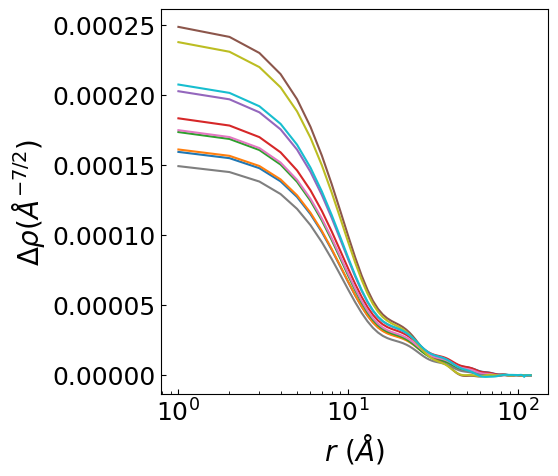

In [3]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(r, rho[:, :], '-')
ax.set_xscale('log')
ax.set_xlabel(r'$r\ (\AA)$', fontsize=20)
ax.set_ylabel(r'$\Delta\rho (\AA^{-7/2})$', fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18)
ax.legend(fontsize=16, frameon=False)

## evaluate the uniform ball radius

In [4]:
R_uniform_list = []
V_list = []
for i in range(rho.shape[1]):
    rho_i = rho[:, i]
    rho_i0 = rho_i[0]
    
    integral_rho_i = np.trapz(rho_i * 4 * np.pi * r**2, r) # int rho(r)*4pi*r^2*dr
    V = integral_rho_i / rho_i0 # V = int rho(r)*4pi*r^2*dr / rho(0)
    R_uniform = (3 * V / (4 * np.pi))**(1/3) # R_uniform = (3 * V / (4 * np.pi))**(1/3)
    
    R_uniform_list.append(R_uniform)
    V_list.append(V)
R_uniform_list = np.array(R_uniform_list)
V_list = np.array(V_list)

## evaluate radius of gyration

In [5]:
R_g_list = []
for i in range(rho.shape[1]):
    rho_i = rho[:, i]
    rho_i0 = rho_i[0]
    
    # Calculate the radius of gyration
    R_g = np.sqrt(np.trapz(rho_i * 4 * np.pi * r**2 * (r - R_uniform_list[i])**2, r) / np.trapz(rho_i * 4 * np.pi * r**2, r))
    R_g_list.append(R_g)
R_g_list = np.array(R_g_list)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '$R (\\AA)$')

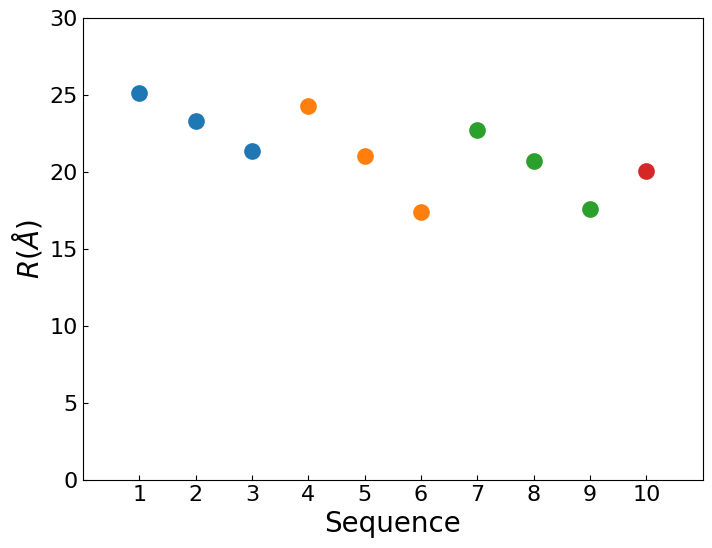

In [6]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

xlabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
colors = ['C0', 'C0', 'C0', 'C1', 'C1', 'C1', 'C2', 'C2', 'C2', 'C3']

for i in range(10):
    ax.plot(i, R_uniform_list[i], 'o', color=colors[i], markersize=10, markeredgewidth=2)

ax.set_xlim([-1, 10])
ax.set_ylim([0, 30])
ax.set_xticks(np.arange(10))
ax.set_xticklabels(xlabels, fontsize=14)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)
ax.legend(fontsize=16, frameon=False)
ax.set_xlabel(r'Sequence', fontsize=20)
ax.set_ylabel(r'$R (\AA)$', fontsize=20)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '$R_g (\\AA)$')

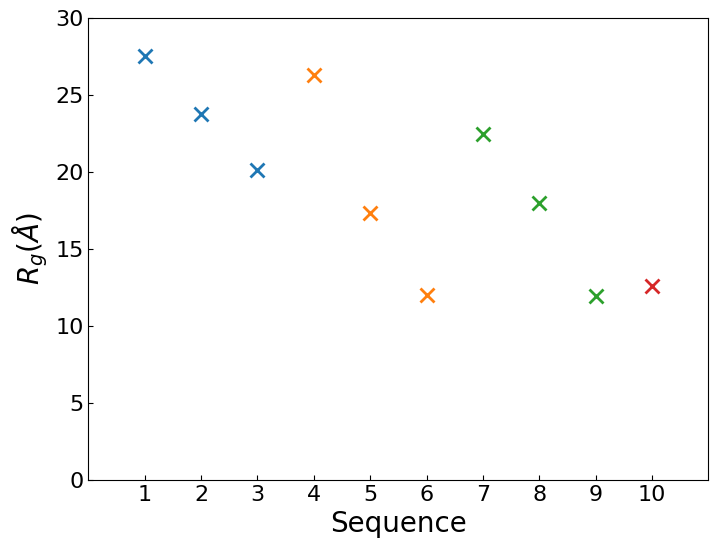

In [7]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

xlabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
colors = ['C0', 'C0', 'C0', 'C1', 'C1', 'C1', 'C2', 'C2', 'C2', 'C3']

for i in range(10):
    ax.plot(i, R_g_list[i], 'x', color=colors[i], markersize=10, markeredgewidth=2)

ax.set_xlim([-1, 10])
ax.set_ylim([0, 30])
ax.set_xticks(np.arange(10))
ax.set_xticklabels(xlabels, fontsize=14)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)
ax.legend(fontsize=16, frameon=False)
ax.set_xlabel(r'Sequence', fontsize=20)
ax.set_ylabel(r'$R_g (\AA)$', fontsize=20)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '$V (\\mathrm{nm}^3)$')

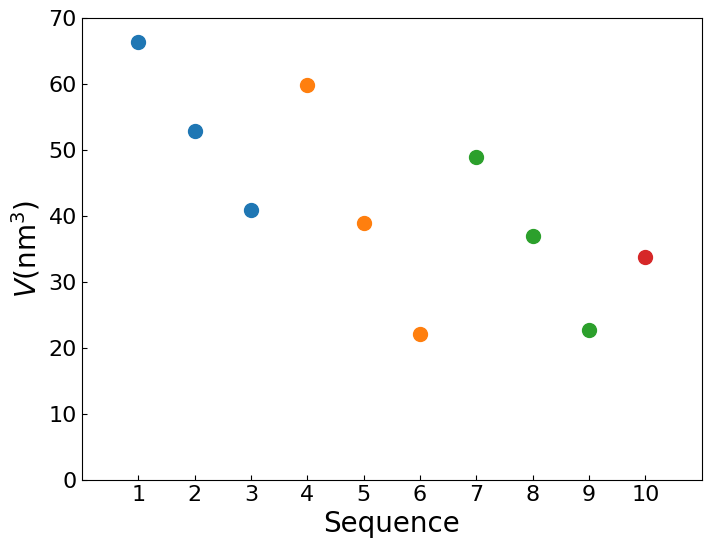

In [8]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

xlabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
colors = ['C0', 'C0', 'C0', 'C1', 'C1', 'C1', 'C2', 'C2', 'C2', 'C3']

for i in range(10):
    ax.plot(i, V_list[i]/1000, 'o', color=colors[i], markersize=10)

ax.set_xlim([-1, 10])
ax.set_ylim([0, 70])
ax.set_xticks(np.arange(10))
ax.set_xticklabels(xlabels, fontsize=14)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)
ax.legend(fontsize=16, frameon=False)
ax.set_xlabel(r'Sequence', fontsize=20)
ax.set_ylabel(r'$V (\mathrm{nm}^3)$', fontsize=20)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '$N_\\mathrm{Agg}$')

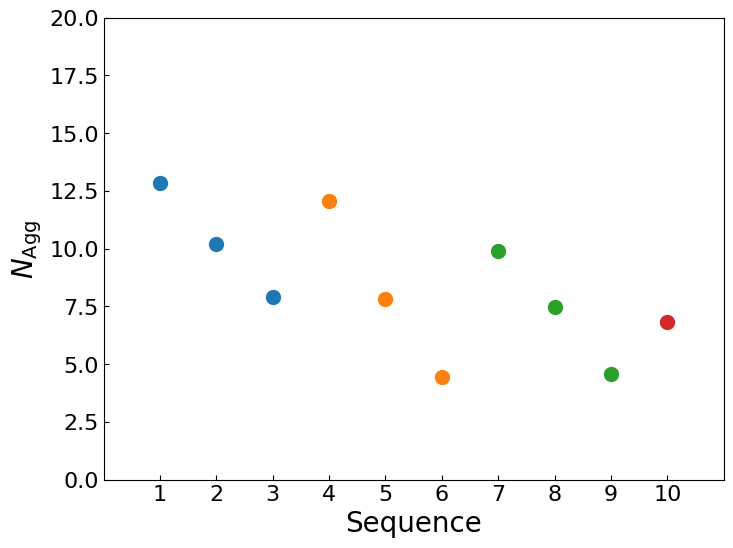

In [9]:
density_sgl = 1.08 # g/cm^3
density_tri = 1.06 # g/cm^3

mC = 12.01 # g/mol
mH = 1.008 # g/mol
mN = 14.01 # g/mol
mO = 16.00 # g/mol

m_sgl = ((mC + mH*3 + mC + mO)
    + (mN + (mC*10 + mH*21) + mC + mH*2 + mC + mO)*5
    + (mN + (mC*2 + mH*4 + mO + mC + mH*3) + mC + mH*2 + mC + mO)*19
    + (mN + mC*3 + mH*4 + mO*2) + mC + mH*2 + mC + mO + (mN + mH*2)*1
       )
m_tri = ((mC + mH*3 + mC + mO)
    + (mN + (mC*10 + mH*21) + mC + mH*2 + mC + mO)*5
    + (mN + (mC*2 + mH*4 + mO + mC + mH*3) + mC + mH*2 + mC + mO)*17
    + (mN + mC*3 + mH*4 + mO*2) + mC + mH*2 + mC + mO + (mN + mH*2)*3
       )

Na = 6.022e23  # Avogadro's number in mol^-1

# Calculate volume per molecule according to density and molar mass
# Volume per molecule (cm^3) = molar mass / (Na * density)
V_sgl = m_sgl / (Na * density_sgl)
V_tri = m_tri / (Na * density_tri)

# Convert to nm^3
V_sgl_nm3 = V_sgl * 1e21
V_tri_nm3 = V_tri * 1e21

v_seq = [V_sgl_nm3, V_sgl_nm3, V_sgl_nm3, V_tri_nm3, V_tri_nm3, V_tri_nm3, V_tri_nm3, V_tri_nm3, V_tri_nm3, V_tri_nm3]

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

xlabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
colors = ['C0', 'C0', 'C0', 'C1', 'C1', 'C1', 'C2', 'C2', 'C2', 'C3']

for i in range(10):
    ax.plot(i, V_list[i]/1000/v_seq[i], 'o', color=colors[i], markersize=10)

ax.set_xlim([-1, 10])
ax.set_ylim([0, 20])
ax.set_xticks(np.arange(10))
ax.set_xticklabels(xlabels, fontsize=14)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)
ax.legend(fontsize=16, frameon=False)
ax.set_xlabel(r'Sequence', fontsize=20)
ax.set_ylabel(r'$N_\mathrm{Agg}$', fontsize=20)